In [1]:
import torch
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
import sys
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
import time
import copy
import matplotlib.pyplot as plt
import os
import random

seed=42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Normalisation des images pour les modèles pré-entraînés PyTorch

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [4]:
test_directory = "/content/gdrive/MyDrive/GitHub/ProjetFromage/augmentated_data/test/"
dataset_test = datasets.ImageFolder(test_directory, data_transforms)

# split en train, val et test à partir de la liste complète
np.random.seed(42)
samples_test = dataset_test.samples

print("Nombre d'images de test : %i" % len(samples_test))

Nombre d'images de test : 954


In [5]:
# détermination du nombre de classes
# vérification que les labels sont bien dans [0, nb_classes]
labels=[x[1] for x in samples_test]
if np.min(labels) != 0:
    print("Error: labels should start at 0 (min is %i)" % np.min(labels))
    sys.exit(-1)
if np.max(labels) != (len(np.unique(labels))-1):
    print("Error: labels should go from 0 to Nclasses (max label = {}; Nclasse = {})".format(np.max(labels),len(np.unique(labels)))  )
    sys.exit(-1)
nb_classes = np.max(labels)+1
print("Apprentissage sur {} classes".format(nb_classes))

Apprentissage sur 43 classes


In [6]:
# on définit le device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


In [7]:
#Chargement des modèles
criterion = nn.CrossEntropyLoss()

ResNetTL_model=torch.load("/content/gdrive/MyDrive/GitHub/ProjetFromage/ResNetTL_model.pth")
ResNetFT_model=torch.load("/content/gdrive/MyDrive/GitHub/ProjetFromage/ResNetFT_model.pth")
MobileNetTL_model=torch.load("/content/gdrive/MyDrive/GitHub/ProjetFromage/MobileNetTL_model.pth")
MobileNetFT_model=torch.load("/content/gdrive/MyDrive/GitHub/ProjetFromage/MobileNetFT_model.pth")

In [46]:
def evaluate(model, dataset):
    pred_hard, pred_soft = [], []
    avg_loss = 0.
    avg_accuracy = 0
    loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False, num_workers=2)
    for data in loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        n_correct = torch.sum(preds == labels)
        avg_loss += loss.item()
        avg_accuracy += n_correct
        sm = nn.Softmax(dim=0)
        for i in range(len(labels)):
          probabilities = sm(outputs[i]) #on met sous forme de probabilité
          prob_arr = (probabilities.detach().cpu().numpy())
          pred_label=preds[i].detach().cpu().numpy()
          pred_hard.append(pred_label)
          pred_soft.append(prob_arr)

    
        
    print("Model Accuracy =",float(avg_accuracy) / len(dataset))
    print("\n")
    return pred_hard, pred_soft

In [47]:
ResNetTL_hard, ResNetTL_soft = evaluate(ResNetTL_model, dataset_test)
ResNetFT_hard, ResNetFT_soft = evaluate(ResNetFT_model, dataset_test)
MobileNetTL_hard, MobileNetTL_soft = evaluate(MobileNetTL_model, dataset_test)
MobileNetFT_hard, MobileNetFT_soft = evaluate(MobileNetFT_model, dataset_test)

Model Accuracy = 0.6415094339622641


Model Accuracy = 0.8029350104821803


Model Accuracy = 0.6865828092243187


Model Accuracy = 0.7861635220125787




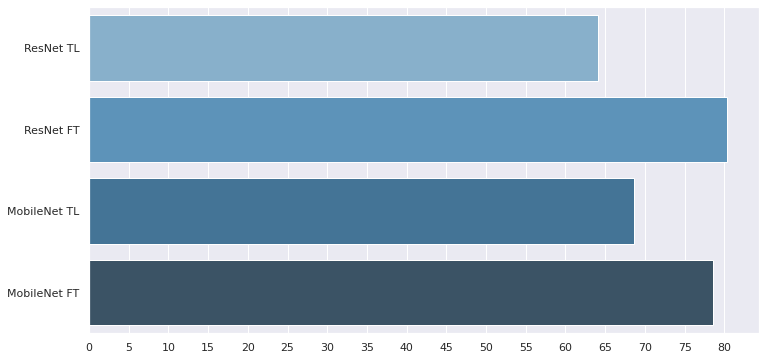

In [122]:
import seaborn as sns
from sklearn.metrics import accuracy_score,confusion_matrix
import matplotlib.ticker as ticker
import pandas as pd

true_labels = []
#getting true labels
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=16, shuffle=False, num_workers=2)
for _, labels in test_loader:
    for x in range(len(labels)):
        true_labels.append(labels[x].item())

def plot_model_accuracies():
    scores = []
    model_acc = {'ResNet TL':ResNetTL_hard, 'ResNet FT':ResNetFT_hard, 'MobileNet TL':MobileNetTL_hard,
                 'MobileNet FT':MobileNetFT_hard}
    for model_pred in model_acc.values():
        scores.append((accuracy_score(true_labels, model_pred))*100)
    sns.set_theme(style="whitegrid")
    sns.set(rc={'figure.figsize':(12,6)})
    ax = sns.barplot(y=list(model_acc.keys()), x=scores, palette="Blues_d", orient='h')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

plot_model_accuracies()

In [105]:
df_hard_voting = pd.DataFrame.from_dict({'ResNet TL':ResNetTL_hard, 'ResNet FT':ResNetFT_hard, 'MobileNet TL':MobileNetTL_hard,
                 'MobileNet FT':MobileNetFT_hard})

df_soft_voting = pd.DataFrame.from_dict({'ResNet TL':ResNetTL_soft, 'ResNet FT':ResNetFT_soft, 'MobileNet TL':MobileNetTL_soft,
                 'MobileNet FT':MobileNetFT_soft})

**Ensemble Hard Voting**

In [106]:
ensemble_hard_predictions = np.asarray(df_hard_voting.mode(axis=1)[0])
arr_pred_hard=[]
for pred_hard in ensemble_hard_predictions:
  arr_pred_hard.append(int(pred_hard))
ensemble_hard_score = accuracy_score(np.asarray(true_labels), arr_pred_hard)
print(f"The Accuracy Score of Hard Voting Ensemble is:  {(ensemble_hard_score*100):.4f} %")

The Accuracy Score of Hard Voting Ensemble is:  78.8260 %


**Ensemble Soft Voting**

In [107]:
import operator

def get_soft_voting():
    preds = []
    for x in range(len(df_soft_voting)):
        sample = tuple([0]*43)
        for y in range(len(df_soft_voting.columns)):
            sample = tuple(map(operator.add, sample, (tuple(df_soft_voting.iloc[x,y]))))
        sample = tuple(ti/len(sample) for ti in sample)
        element = max(sample)
        idx = sample.index(element)
        preds.append(idx)
    return preds

ensemble_soft_preds = get_soft_voting()

ensemble_soft_score = accuracy_score(np.asarray(true_labels), np.asarray(ensemble_soft_preds))
print(f"The Accuracy Score of Soft Voting Ensemble is:  {(ensemble_soft_score*100):.4f} %")

The Accuracy Score of Soft Voting Ensemble is:  81.4465 %


**Ensemble Weighted soft voting**

In [108]:
def get_weighted_average():
    preds = []
    weights = [0.642, 0.803, 0.687, 0.786]
    for x in range(len(df_soft_voting)):
        sample = tuple([0]*43)
        for y in range(len(df_soft_voting.columns)):
            k = tuple(float(weights[y]) * element for element in (tuple(df_soft_voting.iloc[x,y])))
            sample = tuple(map(operator.add, sample, k))
        sample = tuple(ti/len(sample) for ti in sample)
        element = max(sample)
        idx = sample.index(element)
        preds.append(idx)
    return preds

weighted_soft_preds = get_weighted_average()
weighted_soft_score = accuracy_score(np.asarray(true_labels), np.asarray(weighted_soft_preds))
print(f"The Accuracy Score of Weighted Soft Voting Ensemble is:  {(weighted_soft_score*100):.4f} %")

The Accuracy Score of Weighted Soft Voting Ensemble is:  81.2369 %


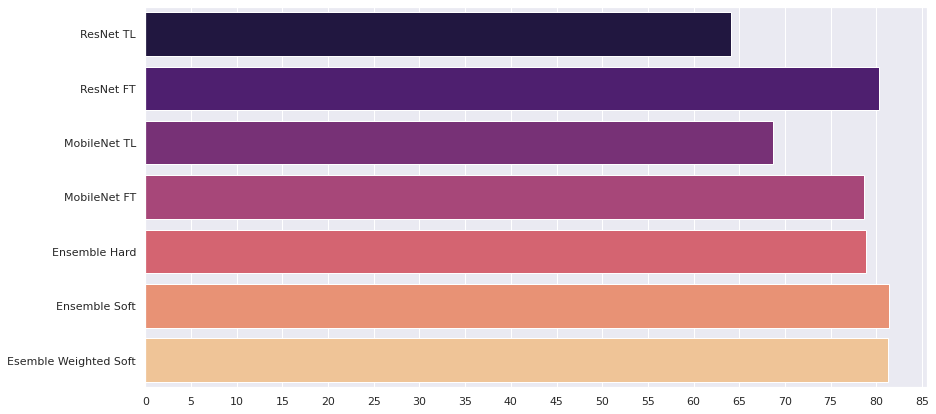

In [109]:
def plot_final_accuracies():
    scores = []
    model_acc = {'ResNet TL':ResNetTL_hard, 'ResNet FT':ResNetFT_hard, 'MobileNet TL':MobileNetTL_hard,
                 'MobileNet FT':MobileNetFT_hard,
                 'Ensemble Hard': arr_pred_hard,
                 'Ensemble Soft': ensemble_soft_preds,
                 'Esemble Weighted Soft':weighted_soft_preds}

    for model_pred in model_acc.values():
        scores.append((accuracy_score(true_labels, model_pred))*100)
    sns.set_theme(style="whitegrid")
    sns.set(rc={'figure.figsize':(14,7)})
    ax = sns.barplot(y=list(model_acc.keys()), x=scores, palette="magma", orient='h')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

plot_final_accuracies()

**Ensemble Hard Voting (best two models)**

In [110]:
df_hard_voting = pd.DataFrame.from_dict({'ResNet FT':ResNetFT_hard,
                 'MobileNet FT':MobileNetFT_hard})

df_soft_voting = pd.DataFrame.from_dict({'ResNet FT':ResNetFT_soft,  'MobileNet FT':MobileNetFT_soft})

In [111]:
ensemble_hard_predictions_best2 = np.asarray(df_hard_voting.mode(axis=1)[0])
arr_pred_hard_best2=[]
for pred_hard in ensemble_hard_predictions_best2:
  arr_pred_hard_best2.append(int(pred_hard))
ensemble_hard_score_best2 = accuracy_score(np.asarray(true_labels), arr_pred_hard_best2)
print(f"The Accuracy Score of Hard Voting Ensemble is:  {(ensemble_hard_score_best2*100):.4f} %")

The Accuracy Score of Hard Voting Ensemble is:  80.5031 %


**Ensemble Soft Voting (best two models)**

In [112]:

def get_soft_voting():
    preds = []
    for x in range(len(df_soft_voting)):
        sample = tuple([0]*43)
        for y in range(len(df_soft_voting.columns)):
            sample = tuple(map(operator.add, sample, (tuple(df_soft_voting.iloc[x,y]))))
        sample = tuple(ti/len(sample) for ti in sample)
        element = max(sample)
        idx = sample.index(element)
        preds.append(idx)
    return preds

ensemble_soft_preds_best2 = get_soft_voting()

ensemble_soft_score_best2 = accuracy_score(np.asarray(true_labels), np.asarray(ensemble_soft_preds_best2))
print(f"The Accuracy Score of Soft Voting Ensemble is:  {(ensemble_soft_score_best2*100):.4f} %")

The Accuracy Score of Soft Voting Ensemble is:  81.3417 %


**Ensemble weighted soft voting (best two models)**

In [113]:
def get_weighted_average():
    preds = []
    weights = [0.803, 0.786]
    for x in range(len(df_soft_voting)):
        sample = tuple([0]*43)
        for y in range(len(df_soft_voting.columns)):
            k = tuple(float(weights[y]) * element for element in (tuple(df_soft_voting.iloc[x,y])))
            sample = tuple(map(operator.add, sample, k))
        sample = tuple(ti/len(sample) for ti in sample)
        element = max(sample)
        idx = sample.index(element)
        preds.append(idx)
    return preds

weighted_soft_preds_best2 = get_weighted_average()
weighted_soft_score_best2 = accuracy_score(np.asarray(true_labels), np.asarray(weighted_soft_preds_best2))
print(f"The Accuracy Score of Weighted Soft Voting Ensemble is:  {(weighted_soft_score_best2*100):.4f} %")

The Accuracy Score of Weighted Soft Voting Ensemble is:  81.4465 %


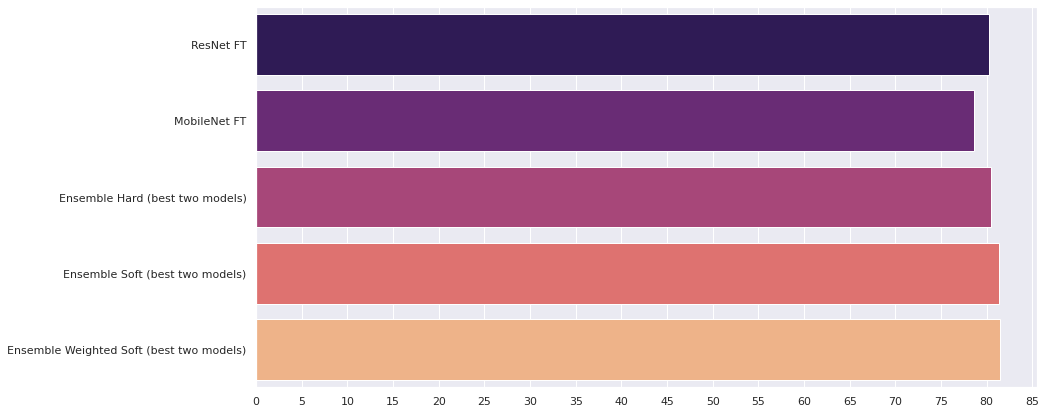

In [114]:
def plot_final_accuracies():
    scores = []
    model_acc = {'ResNet FT':ResNetFT_hard,
                 'MobileNet FT':MobileNetFT_hard,
                 'Ensemble Hard (best two models)':arr_pred_hard_best2,
                 'Ensemble Soft (best two models)':ensemble_soft_preds_best2,
                 'Ensemble Weighted Soft (best two models)':weighted_soft_preds_best2}
    for model_pred in model_acc.values():
        scores.append((accuracy_score(true_labels, model_pred))*100)
    sns.set_theme(style="whitegrid")
    sns.set(rc={'figure.figsize':(14,7)})
    ax = sns.barplot(y=list(model_acc.keys()), x=scores, palette="magma", orient='h')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

plot_final_accuracies()